In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from typing import Callable, List, Tuple

from data.flood_event_1d2d_dataset import FloodEvent1D2DDataset
from utils import file_utils, plot_utils

### Dataset Visualization

In [2]:
config_path = 'configs/config_1d2d_model2.yaml'
config = file_utils.read_yaml_file(config_path)

In [3]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
previous_timesteps = dataset_parameters['previous_timesteps']
dataset = FloodEvent1D2DDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_2d_shp_file=dataset_parameters['nodes_2d_shp_file'],
    edges_2d_shp_file=dataset_parameters['edges_2d_shp_file'],
    nodes_1d_shp_file=dataset_parameters['nodes_1d_shp_file'],
    edges_1d_shp_file=dataset_parameters['edges_1d_shp_file'],
    edges_1d2d_shp_file=dataset_parameters['edges_1d2d_shp_file'],
    dem_file=dataset_parameters['dem_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
    save=True,
    perimeter_name=dataset_parameters['perimeter_name'],
    network_name=dataset_parameters['network_name']
)

HecRas Files: ['HEC-RAS_Results/Davis_Pipe_Model.p22.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p23.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p24.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p25.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p26.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p27.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p28.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p29.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p30.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p31.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p32.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p33.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p34.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p35.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p36.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p37.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p38.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p39.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p40.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p41.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p42.hdf', 'HEC-RAS_Results/Davis_Pipe_Model.p43.hdf', 'HEC-RAS_Results/

In [4]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 79
Total number of timesteps: 24317


In [5]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
tick_interval_in_hours = 12

In [6]:
def plot_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Callable = None,
    mask: np.ndarray = None,
):
    longest_hours_elapsed = []
    for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_paths):
        data = np.load(path)[data_key][previous_timesteps:]
        feature_data = data[start_ts:end_ts, :, feature_idx]

        if mask is not None:
            # print(f'Applying mask: {mask}')
            feature_data = feature_data[:, mask]

        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)

        if aggregation_func is not None:
            feature_data = aggregation_func(feature_data)

        # Plot
        hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
        plt.plot(hours_elapsed, feature_data, label=f'Run {run_id}')

        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed

    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
    plt.xticks(longest_hours_elapsed[interval_ticks])
    plt.ylabel(ylabel)
    plt.show()

# Plot 2D Node Features

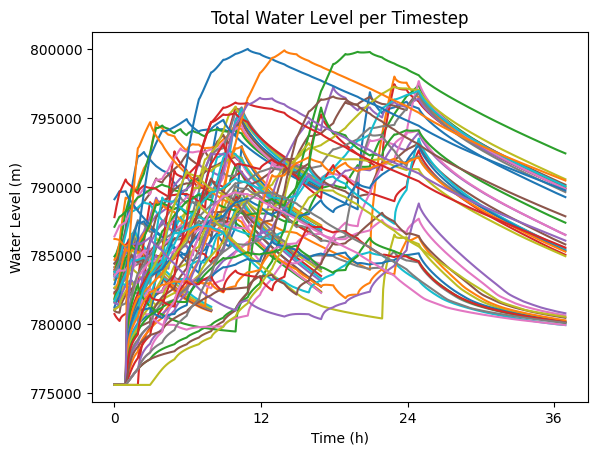

In [7]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
water_volume_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='water_level',
    feature_idx=water_volume_idx,
    ylabel='Water Level (m)',
    title='Total Water Level per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

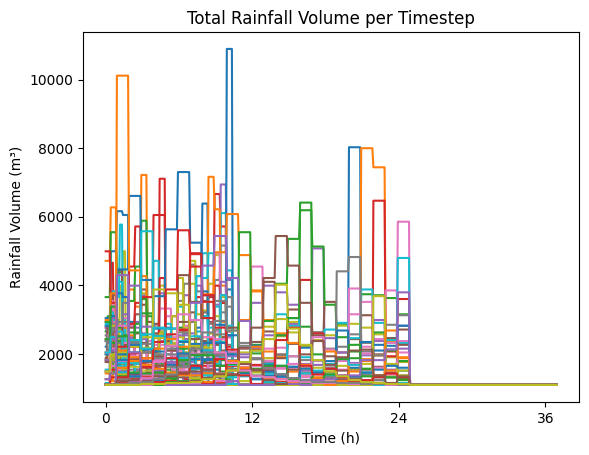

In [8]:
rainfall_idx = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall Volume (m³)',
    title='Total Rainfall Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

# Plot 1D Dynamic Node Features

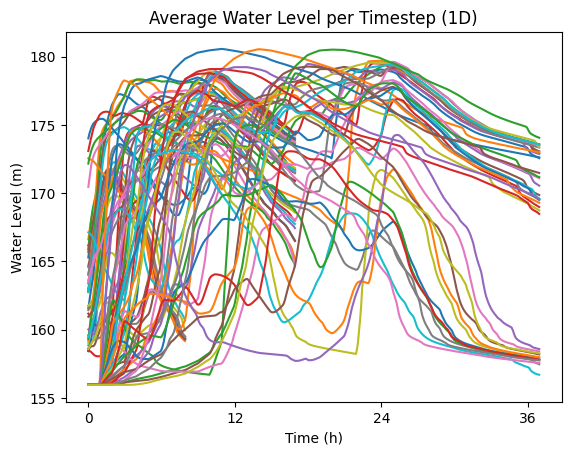

In [9]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('water_level')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='water_level',
    feature_idx=water_level_idx,
    ylabel='Water Level (m)',
    title='Average Water Level per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

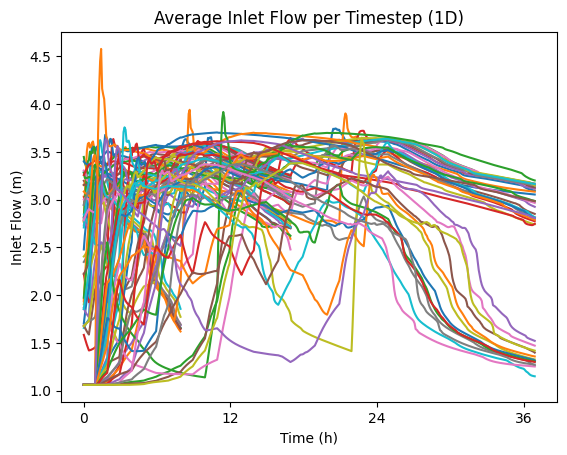

In [10]:
dynamic_nodes_1d_paths = dataset.processed_paths[4:(num_events + 4)]
node_1d_data_key = 'dynamic_nodes_1d'
water_level_idx = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES.index('inlet_flow')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_1d_paths,
    data_key=node_1d_data_key,
    feature_name='inlet_flow',
    feature_idx=water_level_idx,
    ylabel='Inlet Flow (m)',
    title='Average Inlet Flow per Timestep (1D)',
    aggregation_func=lambda x: x.mean(axis=1),
)

# Plot 2D Dynamic Edge Features

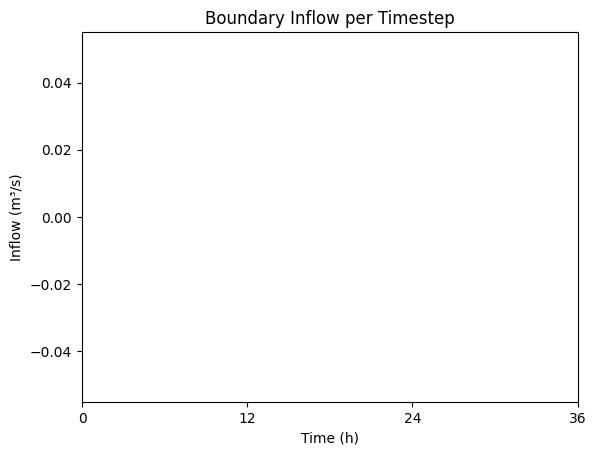

In [11]:
# Plot total inflow per timestep
dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]
edge_data_key = 'dynamic_edges'
flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index('flow')
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

plot_timeseries_per_event(
    dynamic_paths=dynamic_edges_paths,
    data_key=edge_data_key,
    feature_name='flow',
    feature_idx=flow_idx,
    ylabel='Inflow (m³/s)',
    title='Boundary Inflow per Timestep',
    mask=inflow_edge_mask,
)

In [12]:
event_end_idx = [*dataset.event_start_idx, dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 21 - Event Size: 95 timesteps
Run 22 - Event Size: 95 timesteps
Run 23 - Event Size: 95 timesteps
Run 24 - Event Size: 95 timesteps
Run 25 - Event Size: 95 timesteps
Run 26 - Event Size: 95 timesteps
Run 27 - Event Size: 95 timesteps
Run 28 - Event Size: 95 timesteps
Run 29 - Event Size: 95 timesteps
Run 30 - Event Size: 95 timesteps
Run 31 - Event Size: 203 timesteps
Run 32 - Event Size: 203 timesteps
Run 33 - Event Size: 203 timesteps
Run 34 - Event Size: 203 timesteps
Run 35 - Event Size: 203 timesteps
Run 36 - Event Size: 203 timesteps
Run 37 - Event Size: 203 timesteps
Run 38 - Event Size: 203 timesteps
Run 39 - Event Size: 203 timesteps
Run 40 - Event Size: 203 timesteps
Run 41 - Event Size: 203 timesteps
Run 42 - Event Size: 203 timesteps
Run 43 - Event Size: 203 timesteps
Run 44 - Event Size: 203 timesteps
Run 45 - Event Size: 203 timesteps
Run 46 - Event Size: 203 timesteps
Run 47 - Event Size: 203 timesteps
Run 48 - Event Size: 203 timesteps
Run 49 - Event Size: 203 times

Nodes with the highest water volume difference:
Node 1464: 41222.48 m
Node 1465: 34563.55 m
Node 2846: 25706.47 m
Node 2891: 25037.19 m
Node 4065: 24951.77 m
Reading HDF file: data/Model2/raw/HEC-RAS_Results/Davis_Pipe_Model.p22.hdf
Init inflow boundary nodes:  None
Init outflow boundary nodes:  None


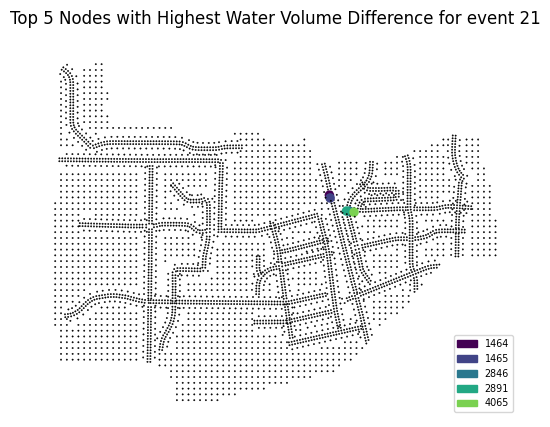

In [13]:
def get_highest_diff_entities(dynamic_path: str,
                              data_key: str,
                              feature_name: str,
                              feature_idx: int,
                              k: int = 4) -> Tuple[List, np.ndarray]:
    data = np.load(dynamic_path)[data_key]
    feature_data = data[:, :, feature_idx]
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    feature_diff = np.abs(np.diff(feature_data, axis=0))
    feature_diff_per_entity = feature_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(feature_diff_per_entity)[-k:][::-1].tolist()
    top_k_wd_diff = feature_diff_per_entity[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff


EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

event_dynamic_nodes_path = dynamic_nodes_paths[EVENT_IDX]
top_k_wv_diff_idx, top_k_wv_diff = get_highest_diff_entities(dynamic_path=event_dynamic_nodes_path,
                                                             data_key=node_data_key,
                                                             feature_name='water_volume',
                                                             feature_idx=water_volume_idx,
                                                             k=k)
print('Nodes with the highest water volume difference:')
for idx, wv in zip(top_k_wv_diff_idx, top_k_wv_diff):
    print(f"Node {idx}: {wv:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
node_df = plot_utils.get_node_df(config, run_id, mode=mode, no_ghost=True, perimeter_name=dataset_parameters['perimeter_name'])
plot_utils.plot_cell_map_w_highlight(gpdf=node_df,
                                     title=f'Top {k} Nodes with Highest Water Volume Difference for event {run_id}',
                                     highlight_idxs=top_k_wv_diff_idx)

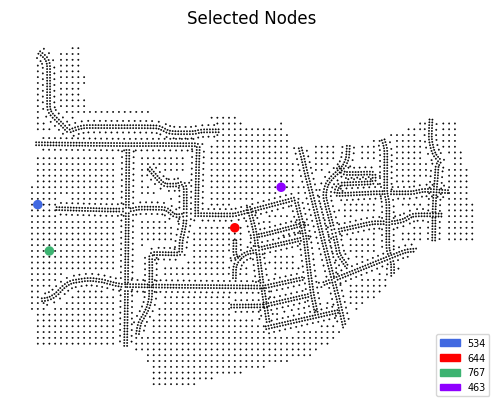

In [14]:
highlight_node_idx = [534, 644, 767, 463]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(node_df,
                                    title='Selected Nodes',
                                    highlight_idxs=highlight_node_idx,
                                    color_list=color_list,
                                    legend=False)

Edges with the highest water flow difference:
Edge 3487: 1106.88 m
Edge 2498: 1100.85 m
Edge 1023: 1091.99 m
Edge 2496: 1043.23 m
Edge 6821: 1023.38 m
Reading HDF file: data/Model2/raw/HEC-RAS_Results/Davis_Pipe_Model.p22.hdf
Init inflow boundary nodes:  None
Init outflow boundary nodes:  None


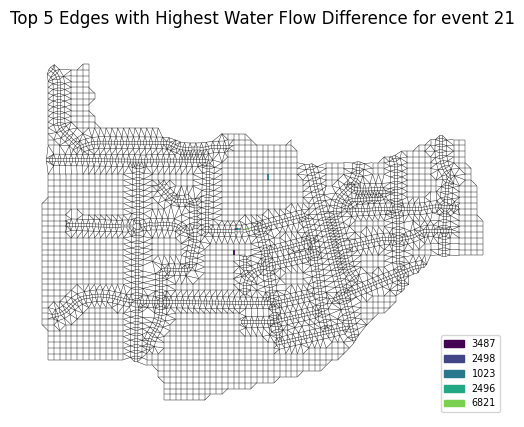

In [15]:
def get_highest_diff_water_flow_edges(dataset: FloodEvent1D2DDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES.index(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEvent1D2DDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

# def get_edge_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
#     edges_shp_path = dataset.raw_paths[1]
#     link_df = gpd.read_file(edges_shp_path)

#     if no_ghost:
#         bc = dataset.boundary_condition
#         inflow_boundary_nodes = dataset.inflow_boundary_nodes
#         outflow_boundary_nodes = dataset.outflow_boundary_nodes
#         is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
#         boundary_nodes = np.concat([np.array(dataset.inflow_boundary_nodes), np.array(dataset.outflow_boundary_nodes)])
#         is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
#         link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

#         assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
#         assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

#     return link_df

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

event_dynamic_edges_path = dynamic_edges_paths[EVENT_IDX]
top_k_wf_diff_idx, top_k_wf_diff = get_highest_diff_entities(dynamic_path=event_dynamic_edges_path,
                                                             data_key=edge_data_key,
                                                             feature_name='flow',
                                                             feature_idx=flow_idx,
                                                             k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_wf_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
edge_df = plot_utils.get_edge_df(config, run_id, mode=mode, no_ghost=True, perimeter_name=dataset_parameters['perimeter_name'])
plot_utils.plot_cell_map_w_highlight(gpdf=edge_df,
                                     title=f'Top {k} Edges with Highest Water Flow Difference for event {run_id}',
                                     highlight_idxs=top_k_wf_diff_idx)

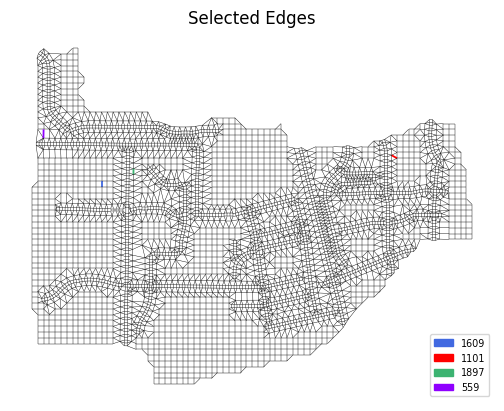

In [16]:
highlight_edge_idx = [1609, 1101, 1897, 559]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(edge_df,
                                     title='Selected Edges',
                                     highlight_idxs=highlight_edge_idx,
                                     color_list=color_list,
                                     legend=True)

In [17]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 15125.8027
	Std: 8464.7715
	Min: 2079.4333
	Max: 53465.6445
aspect
	Mean: 171.1045
	Std: 107.6852
	Min: -1.0000
	Max: 359.9928
curvature
	Mean: 0.0000
	Std: 0.0001
	Min: 0.0000
	Max: 0.0047
elevation
	Mean: 44.1707
	Std: 3.1327
	Min: 34.5625
	Max: 60.4688
face_length
	Mean: 124.3734
	Std: 46.2701
	Min: 16.2832
	Max: 380.7540
flow
	Mean: 7.9954
	Std: 24.4908
	Min: -15.7569
	Max: 303.9036
flow_accumulation
	Mean: 1.7411
	Std: 1.7084
	Min: 1.0000
	Max: 21.0000
inlet_flow
	Mean: 1.0609
	Std: 1.7214
	Min: -3.0850
	Max: 16.1372
length
	Mean: 451.6442
	Std: 453.4415
	Min: 15.3103
	Max: 2557.6387
position_x
	Mean: 6634161.0000
	Std: 2655.5454
	Min: 6628445.0000
	Max: 6639551.0000
position_y
	Mean: 1964248.8750
	Std: 1562.6458
	Min: 1960878.7500
	Max: 1968530.0000
rainfall
	Mean: 0.2544
	Std: 0.5139
	Min: 0.0000
	Max: 15.6833
relative_position_x
	Mean: -0.9546
	Std: 93.8395
	Min: -327.5000
	Max: 332.0000
relative_position_y
	Mean: 17.5447
	Std: 92.1701
	Min: -370

# Plot 2D Static Node & Edge Features

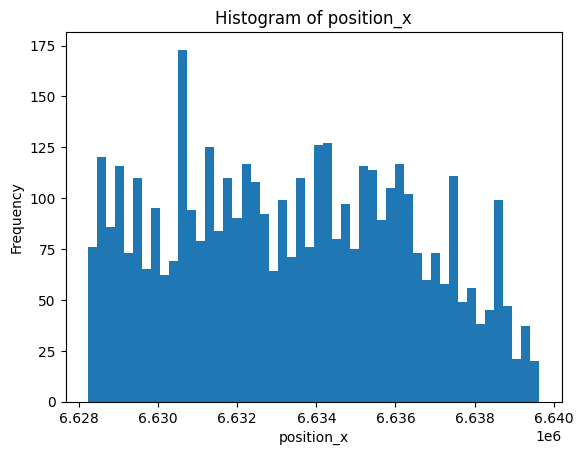

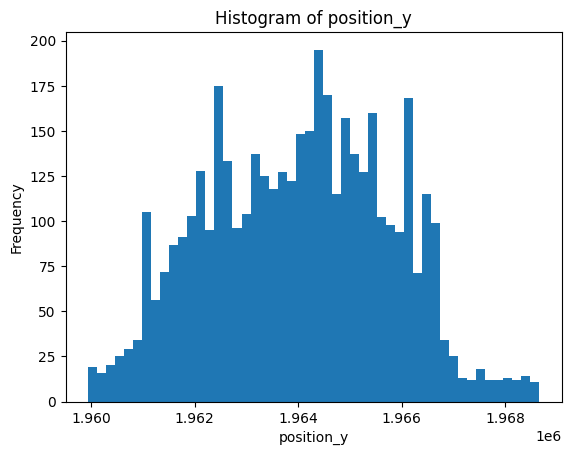

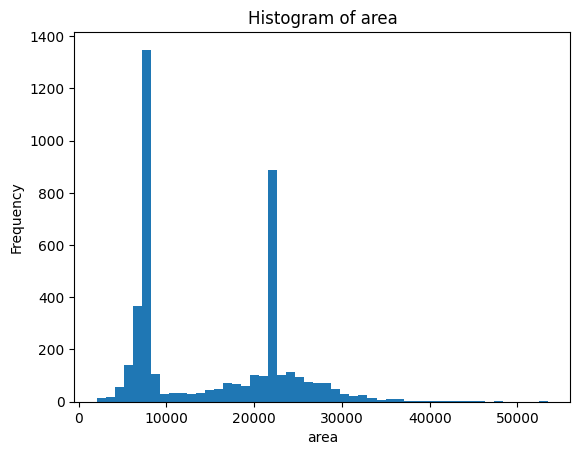

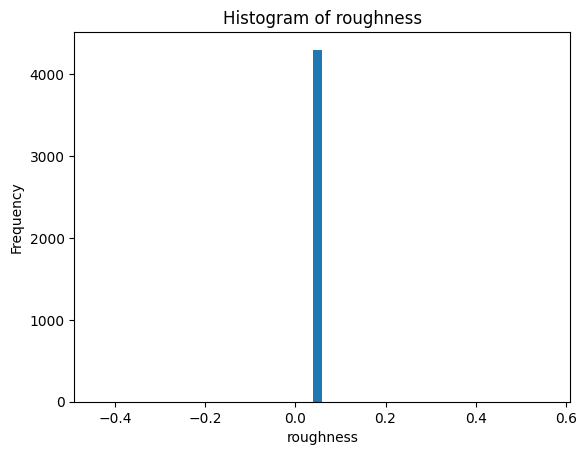

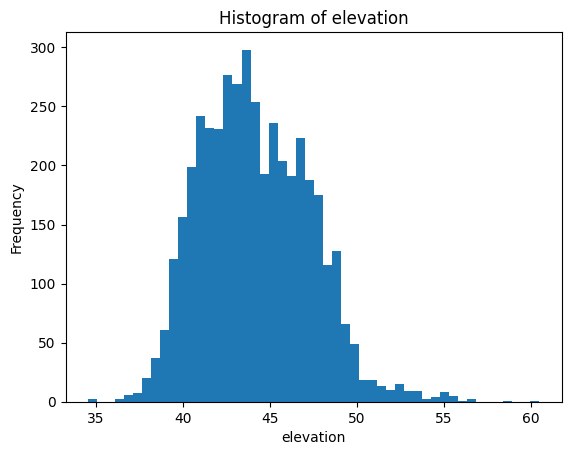

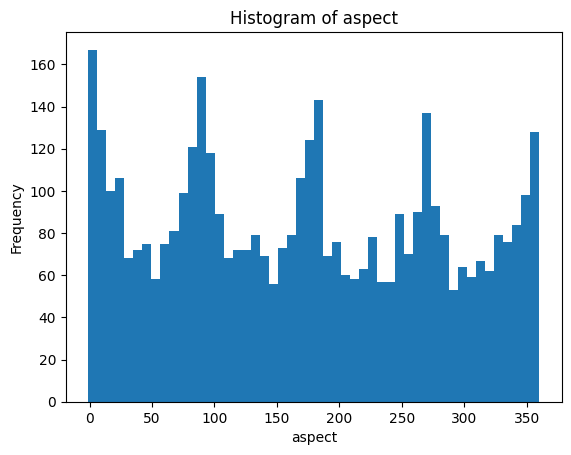

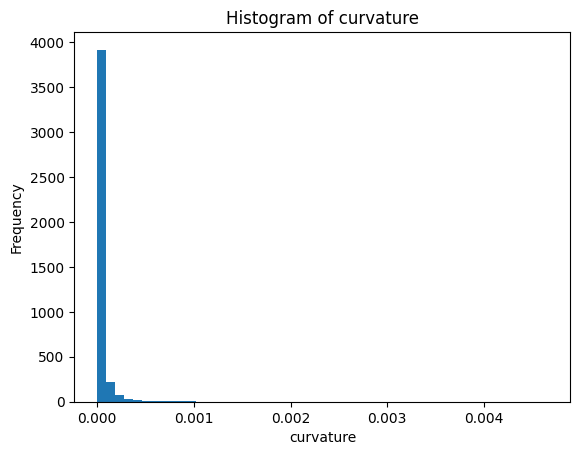

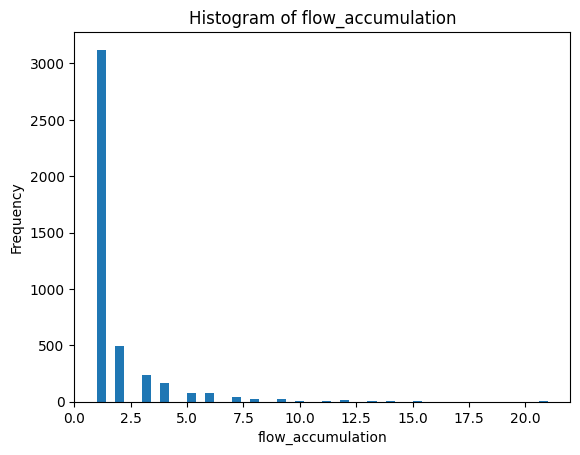

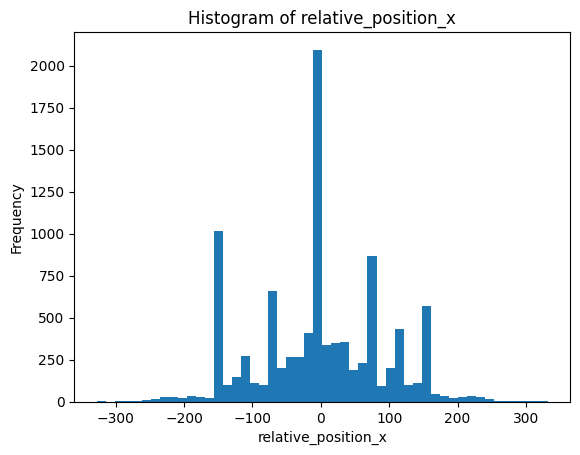

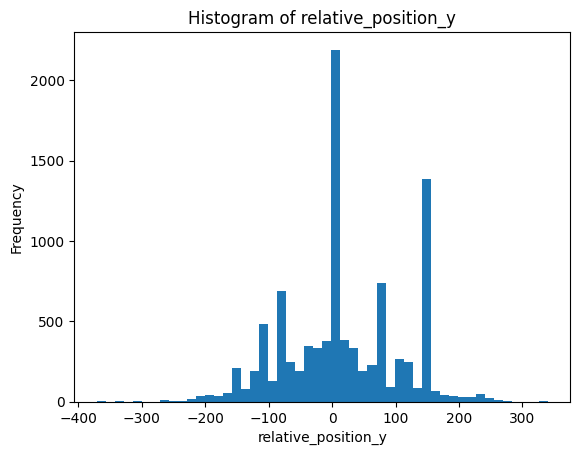

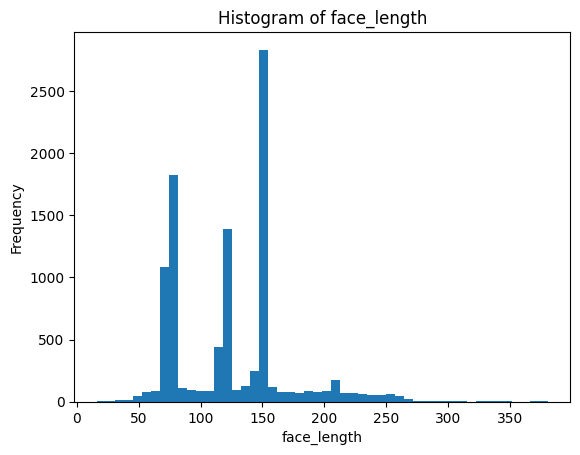

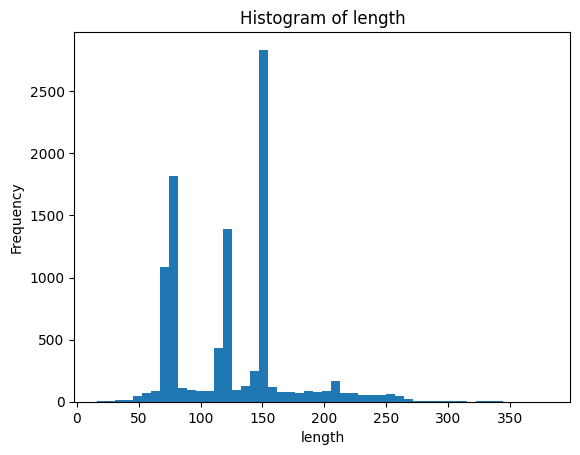

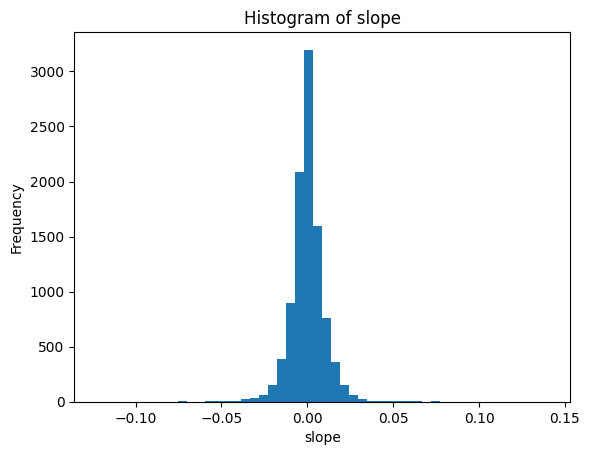

In [18]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 2D Dynamic Node & Edge Features

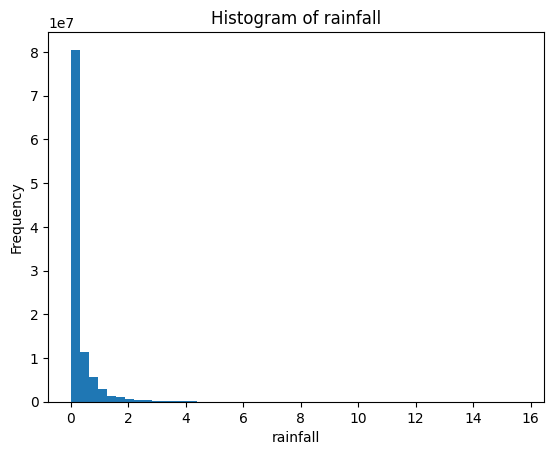

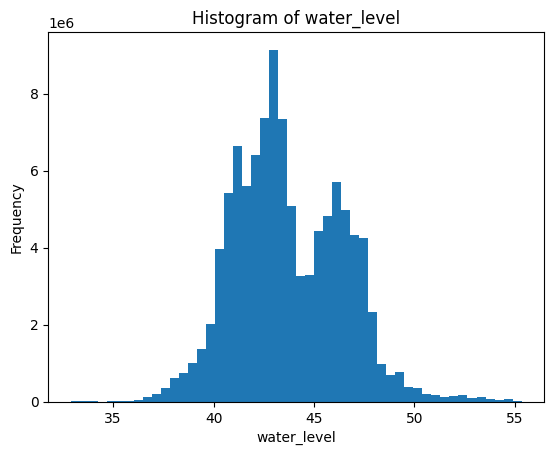

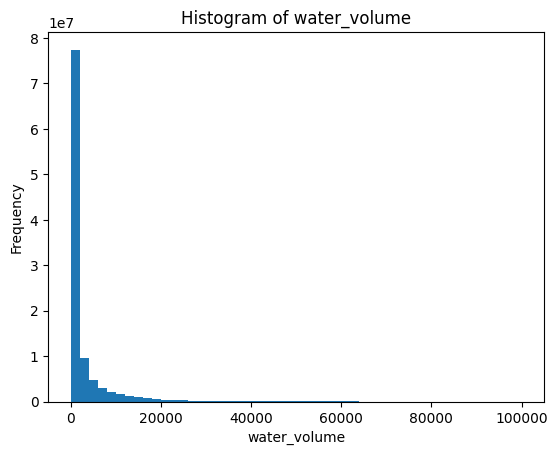

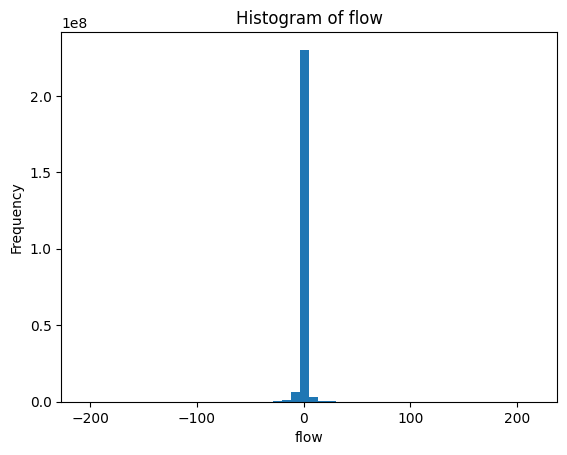

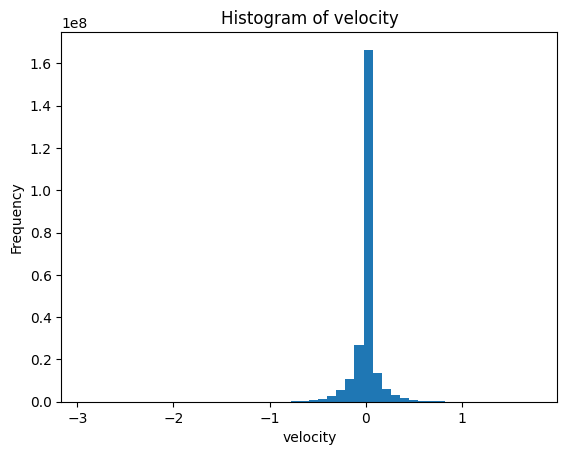

In [19]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# Plot 1D Static Node & Edge Features

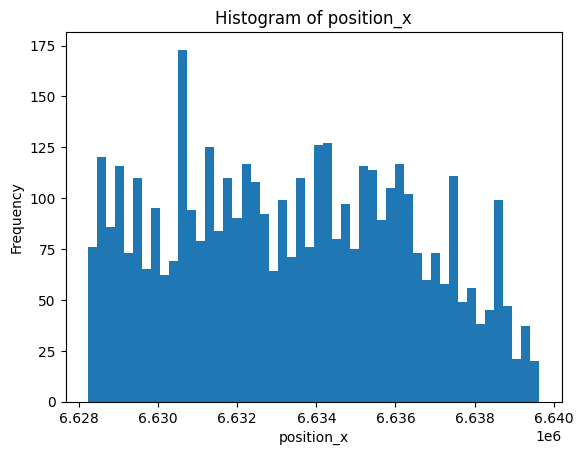

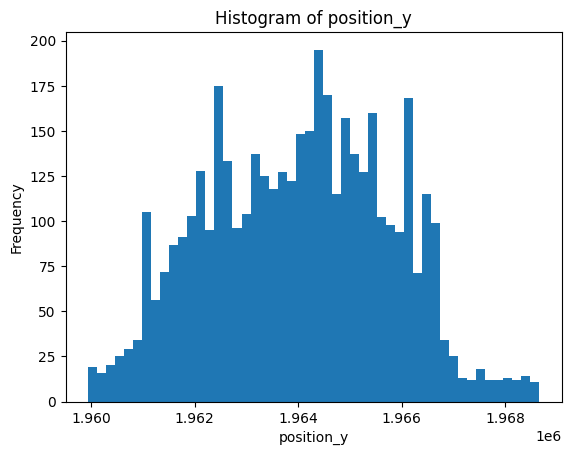

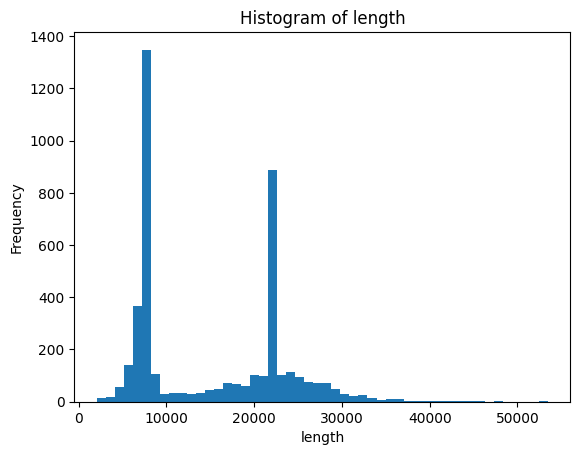

In [20]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEvent1D2DDataset.STATIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.STATIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot 1D Dynamic Node & Edge Features

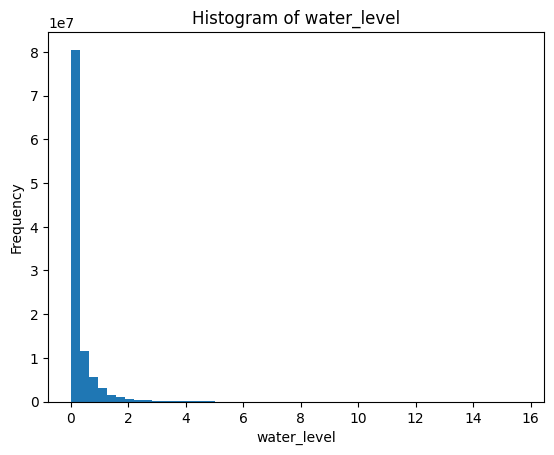

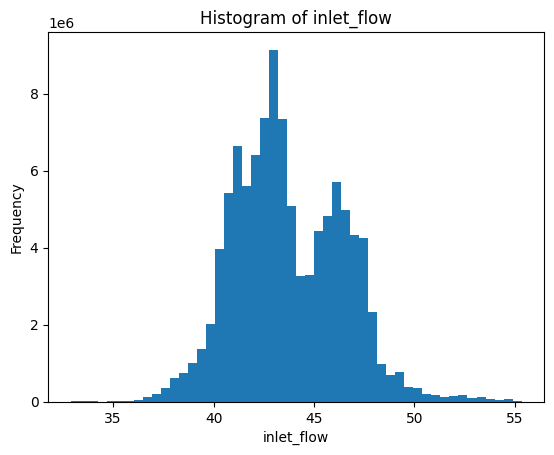

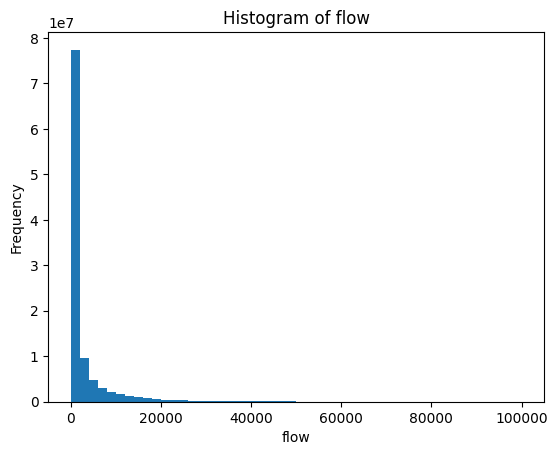

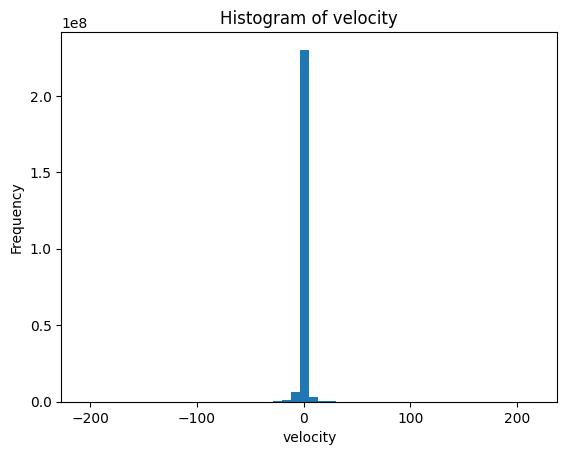

In [21]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEvent1D2DDataset.DYNAMIC_1D_NODE_FEATURES + FloodEvent1D2DDataset.DYNAMIC_1D_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
